<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/pinn_para_edp_acoplada_condi%C3%A7%C3%A3o_Mista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
!pip install pyDOE

In [132]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import Input, Dense
from time import time
from keras.optimizers import Adam
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pyDOE import lhs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import display, Image, HTML

In [133]:
keras.backend.set_floatx('float32')
tf.random.set_seed(0)
k = 1

In [134]:
#Definindo os pontos X
N_0 = 100 #300 pontos para condição inicial
N_bx = 100 #300 pontos para condição de contorno em x
N_by = 100 #300 pontos para a condição de contorno em y
N_r = 10000 #Pontos para a edp

#Pontos do domínio
tmin = 0. ; tmax = 1.
xmin = 0.; xmax = 1.
ymin = 0.; ymax = 1.

#Ponto inferior e superior, respectivamente
lb = tf.constant([tmin, xmin, ymin]); ub = tf.constant([tmax, xmax, ymax])

In [135]:
def c_contorno(t, x, y):
  n = x.shape[0]
  return tf.where(tf.equal(x, 0), tf.ones((n, 1)), tf.zeros((n, 1)))

def p_contorno(t, x, y):
  n = x.shape[0]
  return tf.where(tf.equal(x, 0), tf.ones((n, 1)), tf.zeros((n, 1)))

def c_inicial(x, y):
  return tf.zeros_like(x)

In [136]:
#pontos de contorno, inicial
t0 = tf.zeros((N_0,1))*lb[0]
x0 = tf.random.uniform((N_0,1), lb[1], ub[1]) #Colocando os valores de x0 em ordem aleatoria, indo de 0 a 1
y0 = tf.random.uniform((N_0, 1), lb[2], ub[2])
espaco0 = tf.concat([t0, x0, y0], 1)
c0 = c_inicial(x0,y0)

tbx1 = tf.random.uniform((N_by,1), lb[0], ub[0])
xbx1 = tf.zeros((N_bx,1))
ybx1 = tf.random.uniform((N_by,1), lb[2], ub[2])
espacobx1 = tf.concat([tbx1, xbx1, ybx1], 1)
c_contx1 = c_contorno(tbx1, xbx1, ybx1)
p_contx1 = p_contorno(tbx1, xbx1, ybx1)

tbx2 = tf.random.uniform((N_by,1), lb[0], ub[0])
xbx2 = tf.ones((N_bx,1))
ybx2 = tf.random.uniform((N_by,1), lb[2], ub[2])
espacobx2 = tf.concat([tbx2, xbx2, ybx2], 1)
p_contx2 = p_contorno(tbx2, xbx2, ybx2)

tby1 = tf.random.uniform((N_by,1), lb[0], ub[0])
xby1 = tf.random.uniform((N_by,1), lb[2], ub[2])
yby1 = tf.zeros((N_bx,1))
espacoby1 = tf.concat([tby1, xby1, yby1], 1)

tby2 = tf.random.uniform((N_by,1), lb[0], ub[0])
xby2 = tf.random.uniform((N_by,1), lb[2], ub[2])
yby2 = tf.ones((N_bx,1))
espacoby2 = tf.concat([tby2, xby2, yby2], 1)

#Repetindo o processo, mas agora é para obter os pontos da EDP
tr = tf.random.uniform((N_r,1), lb[0], ub[0])
xr = tf.random.uniform((N_r,1), lb[1], ub[1])
yr = tf.random.uniform((N_r,1), lb[2], ub[2])
espacor = tf.concat([tr, xr,yr], 1)

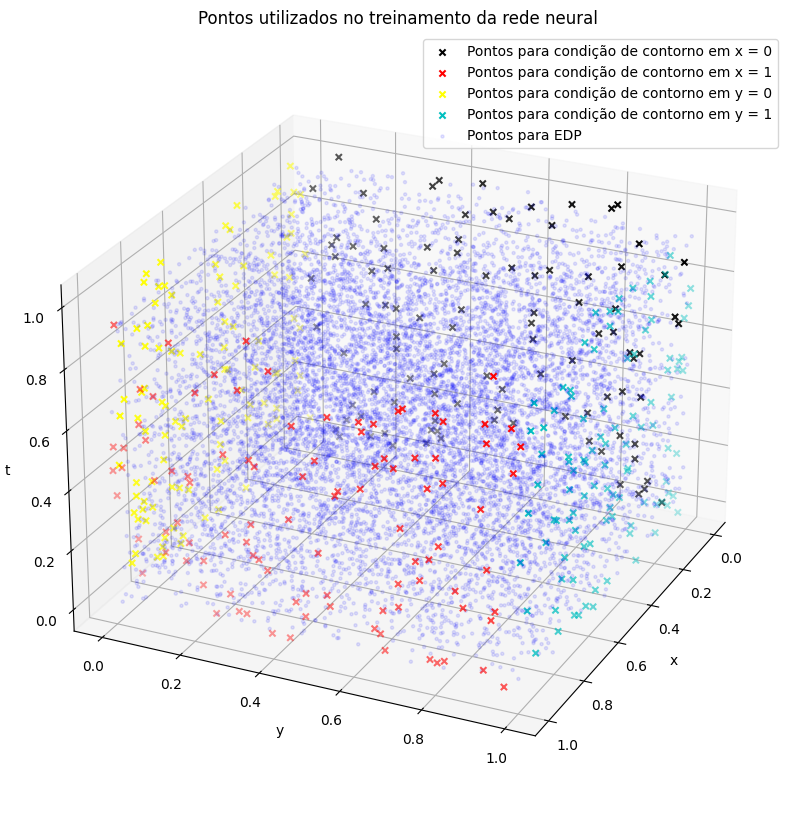

In [137]:
# Plotar os pontos que serão utilizados
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xbx1,ybx1,tbx1, c = 'black', marker ='x', label = 'Pontos para condição de contorno em x = 0')
ax.scatter(xbx2,ybx2,tbx2, c = 'red', marker = 'x', label = 'Pontos para condição de contorno em x = 1')
ax.scatter(xby1,yby1,tby1, c = 'yellow', marker = 'x', label = 'Pontos para condição de contorno em y = 0')
ax.scatter(xby2,yby2,tby2, c = 'c', marker = 'x', label = 'Pontos para condição de contorno em y = 1')
ax.scatter(xr,yr,tr, c = 'blue', marker = '.', alpha = 0.1, label = 'Pontos para EDP')
ax.view_init(25,25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
ax.legend()
ax.set_title('Pontos utilizados no treinamento da rede neural');
plt.show()

In [138]:
#Agora criando o modelo de Rede neural

def modelopinn(nos, camadas_ocultas):
  modelo = Sequential()
  #Inserindo o numero de variaveis de entrada
  modelo.add(Input(3))
  #Escala de entrada, mapeando os pontos de maximo e minimo

  modelo.add(keras.layers.Lambda(
      lambda x: 2.0*(x - lb)/(ub - lb) - 1.0
  ))
  for i in range(camadas_ocultas):
        modelo.add(Dense(nos, activation='tanh', kernel_initializer=GlorotNormal())) #camada oculta

  modelo.add(Dense(2)) #camada de saída
  modelo.summary()
  return modelo

In [139]:
modelo = modelopinn(30,10)

otimizador = Adam(learning_rate = 0.001)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_7 (Lambda)           (None, 3)                 0         
                                                                 
 dense_82 (Dense)            (None, 30)                120       
                                                                 
 dense_83 (Dense)            (None, 30)                930       
                                                                 
 dense_84 (Dense)            (None, 30)                930       
                                                                 
 dense_85 (Dense)            (None, 30)                930       
                                                                 
 dense_86 (Dense)            (None, 30)                930       
                                                                 
 dense_87 (Dense)            (None, 30)               

In [140]:
#E tirando os gradientes, para calcular a edp
def gradiente(modelo, X_r):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    t, x, y = X_r[:, 0:1], X_r[:,1:2], X_r[:,2:3]
    tape.watch(t)
    tape.watch(x)
    tape.watch(y)

    #previsão do modelo
    u = modelo(tf.concat([t, x, y], axis = 1))
    p, c = u[:, 0:1], u[:, 1:2]
    #gradiente du/dx
    f = -( tape.gradient(tape.gradient(p, x), x) + tape.gradient(tape.gradient(p, y), y))
    #gradiente du/dy
    v1 = -tape.gradient(p,x)
    v2 = -tape.gradient(p,y)
    g = tape.gradient(c,t) + tape.gradient(v1*c, x) + tape.gradient(v2*c , y)
    c_x = tape.gradient(c, x)
    c_y = tape.gradient(c, y)
    p_y = tape.gradient(p, y)

  del tape

  return f, g, c_x, c_y, p_y

def neumanncondx2(modelo, espacobx2, p_contx2):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    tx2, xx2, yx2 = espacobx2[:, 0:1], espacobx2[:,1:2], espacobx2[:,2:3]
    tape.watch(tx2)
    tape.watch(xx2)
    tape.watch(yx2)
    #previsão do modelo
    u = modelo(tf.concat([tx2, xx2, yx2], axis = 1))
    p, c = u[:, 0:1], u[:, 1:2]
    c_x = tape.gradient(c, xx2)

    return p, c_x


def neumanncondy2(modelo, espacoby2):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    ty2, xy2, yy2 = espacoby2[:, 0:1], espacoby2[:,1:2], espacoby2[:,2:3]
    tape.watch(ty2)
    tape.watch(xy2)
    tape.watch(yy2)
    #previsão do modelo
    u = modelo(tf.concat([ty2, xy2, yy2], axis = 1))
    p, c = u[:, 0:1], u[:, 1:2]
    p_y = tape.gradient(p, yy2)
    c_y = tape.gradient(c, yy2)

    return p_y, c_y

def neumanncondy1(modelo, espacoby1):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    ty1, xy1, yy1 = espacoby1[:, 0:1], espacoby1[:,1:2], espacoby1[:,2:3]
    tape.watch(ty1)
    tape.watch(xy1)
    tape.watch(yy1)
    #previsão do modelo
    u = modelo(tf.concat([ty1, xy1, yy1], axis = 1))
    p, c = u[:, 0:1], u[:, 1:2]
    p_y = tape.gradient(p, yy1)
    c_y = tape.gradient(c, yy1)

    return p_y, c_y

def MSE(modelo, xr, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2):

    #Erro edp
    f, g, c_x, c_y, p_y = gradiente(modelo, xr)
    erro_p = tf.reduce_mean(tf.square(f))
    erro_c = tf.reduce_mean(tf.square(g))

    loss = erro_p + erro_c
    with tf.GradientTape(persistent=True) as tape:
      #Registrando tempo e posição para a diferenciação automática
      tx1, xx1, yx1 = espacobx1[:, 0:1], espacobx1[:,1:2], espacobx1[:,2:3]
      tape.watch(tx1)
      tape.watch(xx1)
      tape.watch(yx1)
      #previsão do modelo
      u = modelo(tf.concat([tx1, xx1, yx1], axis = 1))
      px1, cx1 = u[:, 0:1], u[:, 1:2]
    u0 = modelo(espaco0)
    p0pred, c0pred = u0[:, 0:1], u0[:, 1:2]

    p_pred, c_x = neumanncondx2(modelo, espacobx2, p_contx2)
    p_y1, c_y = neumanncondy1(modelo, espacoby1)
    p_y2, c_y2 = neumanncondy2(modelo, espacoby2)

    loss += tf.reduce_mean(tf.square(p_contx2 - p_pred))
    loss += tf.reduce_mean(tf.square(c_x))
    loss += tf.reduce_mean(tf.square(p_y1))
    loss += tf.reduce_mean(tf.square(c_y))
    loss += tf.reduce_mean(tf.square(p_y2))
    loss += tf.reduce_mean(tf.square(c_y2))
    loss += tf.reduce_mean(tf.square(p_contx1 - px1))
    loss += tf.reduce_mean(tf.square(c_contx1 - cx1))
    loss += tf.reduce_mean(tf.square(c0 - c0pred))

    return erro_p, erro_c, loss

def grad(modelo, xr, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2):
  #tirando o gradiente em relação ao modelos, para que eles sejam atualizados posteriormente
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(modelo.trainable_variables)
    erro_p, erro_c, loss = MSE(modelo, xr, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2)

  g = tape.gradient(loss, modelo.trainable_variables)
  del tape

  return erro_p, erro_c, loss, g

In [141]:
#etapa de treinamento como uma função do TensorFlow para aumentar a velocidade do treinamento
@tf.function
def train_step(modelo):
  #Calculando a perda do modelo em relação ao modelo, com a função grad
  erro_p, erro_c, loss, grad_theta = grad(modelo, espacor, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2)

  #Aplicando o gradiente as variaveis do modelo de rede neural
  otimizador.apply_gradients(zip(grad_theta, modelo.trainable_variables))

  return erro_p, erro_c, loss

itr = 1400
historico = []
erro_aux_p = []
erro_aux_c = []
t0 = time()

for i in range(itr+1):

    erro_p, erro_c, loss = train_step(modelo)

    #Salvando os erros para listar
    historico.append(loss.numpy())
    erro_aux_p.append(erro_p.numpy())
    erro_aux_c.append(erro_c.numpy())


    if i%100 == 0:
        print(i,"Loss treino: {:10.8e}, Loss edp f: {:10.8e}, Loss edp g: {:10.8e}".format(loss, erro_p, erro_c))

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

0 Loss treino: 5.28489637e+00, Loss edp f: 1.77229857e+00, Loss edp g: 2.23040283e-01
100 Loss treino: 1.83943644e-01, Loss edp f: 6.64698007e-03, Loss edp g: 2.86190119e-02
200 Loss treino: 1.46028429e-01, Loss edp f: 6.46554260e-03, Loss edp g: 1.86677370e-02
300 Loss treino: 1.25547022e-01, Loss edp f: 5.38410805e-03, Loss edp g: 1.48863131e-02
400 Loss treino: 1.21628813e-01, Loss edp f: 6.24381611e-03, Loss edp g: 1.44343944e-02
500 Loss treino: 7.18514696e-02, Loss edp f: 4.91045509e-03, Loss edp g: 7.33201439e-03
600 Loss treino: 7.03246221e-02, Loss edp f: 3.53009067e-03, Loss edp g: 5.80685353e-03
700 Loss treino: 9.51480865e-02, Loss edp f: 4.92627779e-03, Loss edp g: 7.36043090e-03
800 Loss treino: 5.52231036e-02, Loss edp f: 2.64579523e-03, Loss edp g: 3.75434570e-03
900 Loss treino: 8.42643753e-02, Loss edp f: 4.26333444e-03, Loss edp g: 7.24006491e-03
1000 Loss treino: 4.98623289e-02, Loss edp f: 2.02559750e-03, Loss edp g: 3.08966707e-03
1100 Loss treino: 9.78201255e-02,

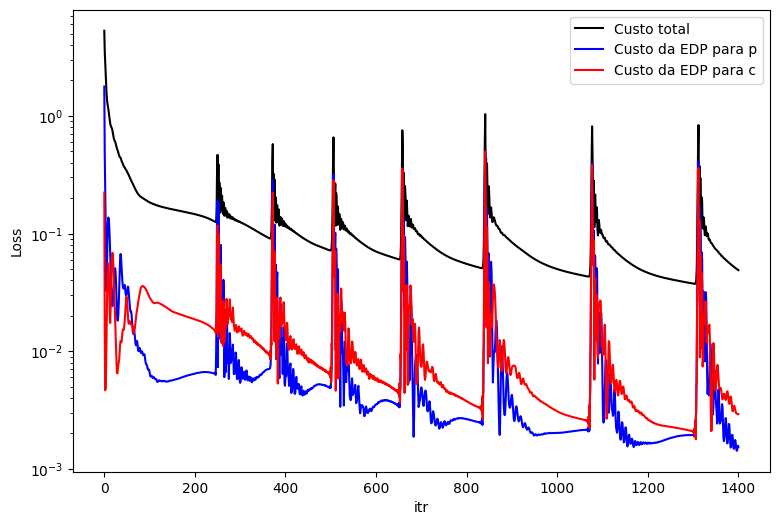

In [142]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(range(len(historico)), historico, 'k-', label='Custo total')
ax.plot(range(len(erro_aux_p)), erro_aux_p, 'b-', label='Custo da EDP para p')
ax.plot(range(len(erro_aux_c)), erro_aux_c, 'r-', label='Custo da EDP para c')
ax.set_yscale('log')
ax.set_xlabel('itr')
ax.set_ylabel('Loss');
ax.legend()
plt.show()

In [143]:
N = 100
xspace = np.linspace(lb[1], ub[1], N + 1)
yspace = np.linspace(lb[2], ub[2], N + 1)

#em t = 0.1
t_01 = 0.1
T, X, Y = np.meshgrid(t_01, xspace, yspace)
X01 = np.vstack([T.flatten(),X.flatten(), Y.flatten()]).T
u = modelo(X01)
p_01, c_01 = u[:, 0:1].numpy().reshape(1, N+1, N+1), u[:, 1:2].numpy().reshape(1, N+1, N+1)

#em t = 0.5s
t_05 = 0.5
T, X, Y = np.meshgrid(t_05, xspace, yspace)
X05 = np.vstack([T.flatten(),X.flatten(), Y.flatten()]).T
u_05 = modelo(X05)
p_05, c_05 = u_05[:, 0:1].numpy().reshape(1, N+1, N+1), u_05[:, 1:2].numpy().reshape(1, N+1, N+1)

#em t=1s
t_1 = 1.0
T,X,Y = np.meshgrid(t_1, xspace, yspace)
X1 = np.vstack([T.flatten(), X.flatten(), Y.flatten()]).T
u_1 = modelo(X1)
p_1, c_1 = u_1[:, 0:1].numpy().reshape(1, N+1, N+1), u_1[:, 1:2].numpy().reshape(1, N+1, N+1)

Xaux, Yaux = np.meshgrid(xspace, yspace)

Text(0.5, 0.92, 'Solução para c = c(t + x + y) em t = 1')

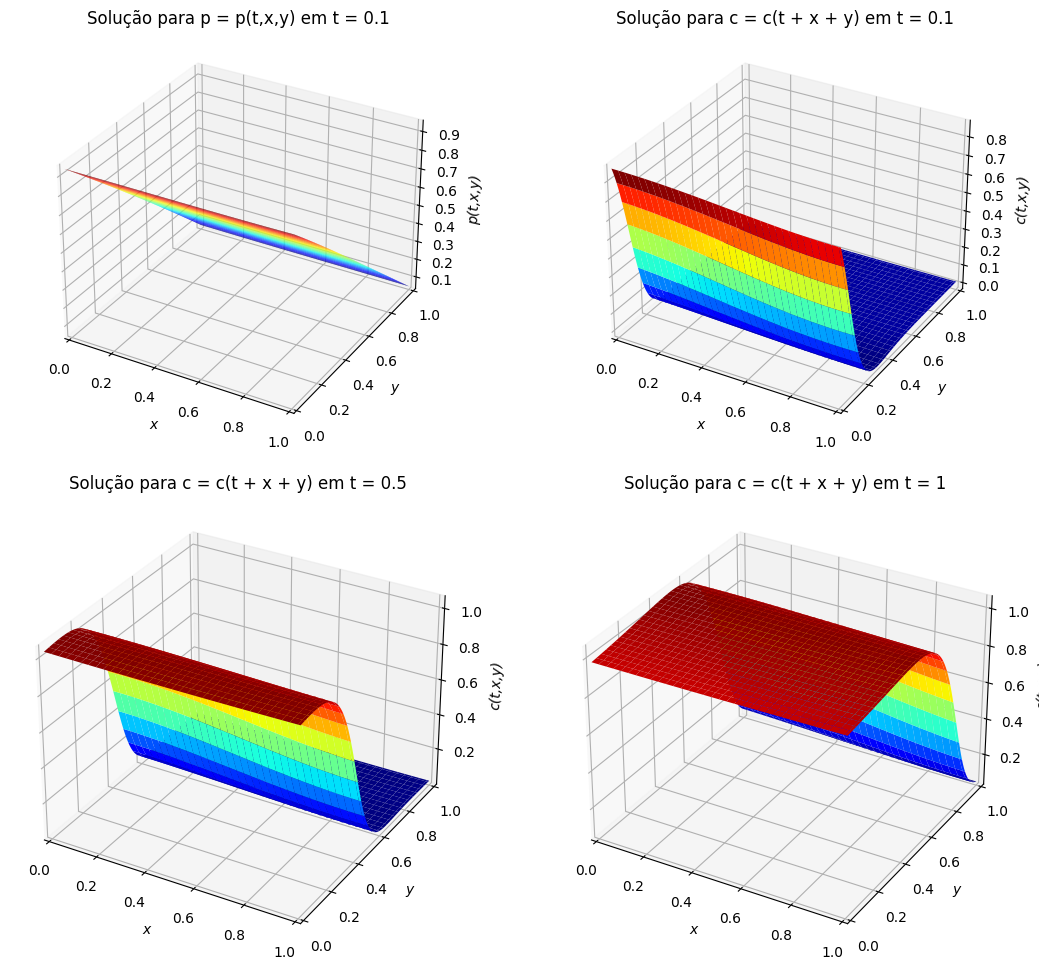

In [144]:
fig  = plt.figure(figsize = (20, 18))
# snapshot 1
ax   = fig.add_subplot(3, 3, 1, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, p_01[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('p(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para p = p(t,x,y) em t = 0.1')

ax   = fig.add_subplot(3, 3, 2, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, c_01[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 0.1')
# snapshot 2
ax   = fig.add_subplot(1, 3, 1, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, c_05[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 0.5')
# snapshot 3
ax   = fig.add_subplot(1, 3, 2, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, c_1[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 1')

In [145]:
tspace = np.linspace(lb[0], ub[0], N + 1)
Tt, Xt, Yt = np.meshgrid(tspace, xspace, yspace)
Xgrid = np.vstack([Tt.flatten(),Xt.flatten(), Yt.flatten()]).T

#Realizando predição
upred = modelo(Xgrid)
c = upred[:,1:2]

In [146]:
C = c.numpy().reshape(N+1,N+1,N+1)

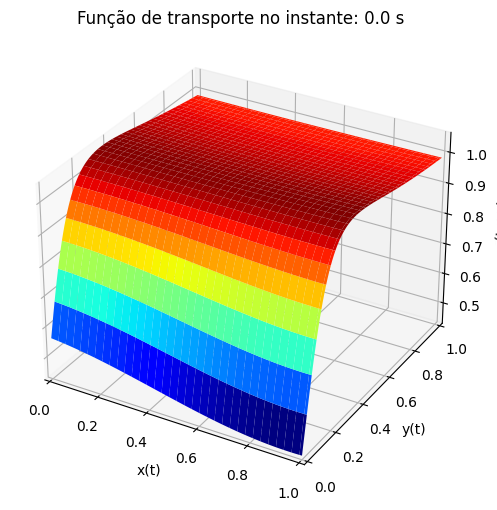

In [148]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

def frame(w):
    ax.clear()

    plt.title("Função de transporte no instante: {:1.4} s".format(tspace[w]))
    ax.set_xlabel('x(t)')
    ax.set_xlim3d(0,1)
    ax.set_ylabel('y(t)')
    ax.set_ylim3d(0,1)
    ax.set_zlabel('c(t,x,y)'.format(tspace[w]))
    #ax.set_zlim3d(-val1,val1)

    plot=ax.plot_surface(Xaux, Yaux, C[w], cmap='jet')


    return plot


anim = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)

anim.save('Função Transporte PINN.gif', writer = "pillow", fps=10 )
HTML(anim.to_html5_video())